# Sentiment Analysis of Covid-19 Tweets

# # Abstract
Κατά την διάρκεια της πανδημίας, πολλοί χρήστες του Twitter Δημοσιεύουν διάφορα Posts που αποτελούν την γνώμη του σχετικά με τον Covid-19. Θα ήταν καλό να γνωρίζουμε το συναίσθημα που προκύπτει από το κάθε post, προκειμένου να δούμε κατά πόσο έχει επηρεαστεί η ψυχολογία του εκάστοτε χρήστη.

Τα δεδομένα που χρησιμοποιήθηκαν κατα τις training/validation διαδικασίες μπορεί κανείς να τα βρεί στο Kaggle στο παρακάτω URL:
https://www.kaggle.com/gauravsahani/covid-19-sentiment-analysis-using-spacy/data

Μπορούμε να κατεβάσουμε τα δεδομένα με την παρακάτω command:

$ kaggle kernels output gauravsahani/covid-19-sentiment-analysis-using-spacy -p /path/to/dest


# # Data Processing
Παρακάτω αφού έχουμε κατεβάσει τα δεδομένα απο το Kaggle, διαβάζουμε το csv file το οποίο αφορά τα δεδομένα του Training.
Όπως θα παρατηρήσουμε στο Kaggle τα δεδομένα μας είναι χωρισμένα σε 2 csv αρχεία. Ένα Train και ένα Test.
Έτσι λοιπόν αφού κάνουμε import τις απαραίτητες βιβλιοθήκες που θα χρειαστούμε μπορούμε να διαβάσουμε τα csv.

In [6]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
import nltk
from nltk.corpus import  wordnet
# nltk.download('wordnet')
from nltk import FreqDist, PorterStemmer, SnowballStemmer, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib
import time
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import feature_selection

data = pd.read_csv(r"Corona_NLP_train.csv", encoding='ansi')
print(data.head(5))

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


Αφού διαβάσαμε τα δεδομένα απο το CSV αρχείο και τα φέραμε σε ένα DataFrame ακολουθεί η επεξεργασια αυτών και η διερεύνηση για το τι δεδομένα έχουμε.

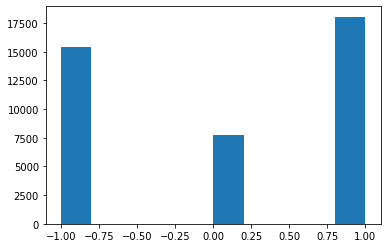

In [7]:
data["Sentiment"] = data["Sentiment"].replace('Extremely Negative', 'Negative', regex=True)

data["Sentiment"] = data["Sentiment"].replace('Extremely Positive', 'Positive', regex=True)

#transform Sentiment to number
#negative=0
#postive=1
#neutral=2
data["Sentiment"]=data["Sentiment"].replace('Negative', -1, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Positive', 1, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Neutral', 0, regex=True)



plt.hist(data["Sentiment"])
plt.show()


Όπως μπορούμε να δούμε για την Class = Negative = -1 έχουμε περίπου 15.500 samples. Ομοίως για τη Class = Positive = 1 έχουμε περίπου 17.500 samples. Τέλος για την Class = Neutral = 0 έχουμε περίπου 7.500 samples.

## Ακολουθεί η διαδικασία του Processing:
Μετά απο πολύ ψάξιμο εντός των δεδομένων παρατήρησα οτι έχουμε κάποιες περίεργες λέξεις και κάποιες λέξεις με απόστροφο. 
Επίσης είναι λογικό σε ένα tweet να βρει κανείς και emojis/emoticons. Όλα αυτά αποθηκεύτηκαν σε κάποια dictionariesμε σκοπό να κάνουμε lookups
για να μπρούμε να τα αντικαθιστούμε ή να τα διαγράφουμε.

In [ ]:
#short words/apostrophe lookup
contraction_dict1 = {"Â":"","’":"'","Ã":""}
contraction_dict2 = {"Â":"","’":"'","ain't": "are not","'s":" is","aren't": "are not","don't": "do not","Don't":"Do not",
                     "I'll":"I will","Didn't":"Did not","hasn't":"has not","NYC":"New York City","16MAR20":"",
                     "I'd":"I would","I've":"I have","you're":"you are","I'm":"I am","it's":"it is",
                     "#NZ":"","they'll":"they will","they're":"they are","can't":"can not","Y'all":"You All",
                     "I m":"I am","can't":"can not","don t":"do not","I ve":"I have","we're":"we are",
                     "LOL":"lough out loud","lol":"lough out loud","FYI":"For your information","OFC":"Of Course","ofc":"Of Course",
                     "#coronavirÃ¼s":"coronavirus","pls":"please","#stayhomesavelives":"stay home save lives",
                     "hasn't": 'has not',"haven't": 'have not',"he'd": 'he had / he would',"he'd've": 'he would have',
                     "he'll": 'he shall / he will',"he'll've": 'he shall have / he will have',
                     "he's": 'he has / he is',"how'd": 'how did', "how'd'y": 'how do you', "how'll": 'how will',
                     "how's": 'how has / how is', "i'd": 'I had / I would',"i'd've": 'I would have',  "i'll": 'I shall / I will',
                     "i'll've": 'I shall have / I will have',"i'm": 'I am', "i've": 'I have', "isn't": 'is not', "it'd": 'it had / it would',
                     "it'd've": 'it would have', "it'll": 'it shall / it will',
                     "it'll've": 'it shall have / it will have',"it's": 'it has / it is', "let's": 'let us',
                     "ma'am": 'madam', "mayn't": 'may not',
                     "might've": 'might have', "mightn't": 'might not',
                     "mightn't've": 'might not have', "must've": 'must have',"mustn't": 'must not',
                     "mustn't've": 'must not have', "needn't": 'need not',
                     "needn't've": 'need not have', "o'clock": 'of the clock',
                     "oughtn't": 'ought not', "oughtn't've": 'ought not have',
                     "shan't": 'shall not', "sha'n't": 'shall not',
                     "shan't've": 'shall not have', "she'd": 'she had / she would',
                     "she'd've": 'she would have', "she'll": 'she shall / she will',
                     "she'll've": 'she shall have / she will have',
                     "she's": 'she has / she is', "should've": 'should have',
                     "shouldn't": 'should not',"shouldn't've": 'should not have',
                     "so've": 'so have', "so's": 'so as / so is',
                     "that'd": 'that would / that had',"that'd've": 'that would have',
                     "that's": 'that has / that is', "there'd": 'there had / there would',
                     "there'd've": 'there would have', "there's": 'there has / there is',
                     "they'd": 'they had / they would',  "they'd've": 'they would have',
                     "they'll": 'they shall / they will', "they'll've": 'they shall have / they will have',
                     "they're": 'they are',  "they've": 'they have',
                     "to've": 'to have', "wasn't": 'was not',
                     "we'd": 'we had / we would',  "we'd've": 'we would have',
                     "we'll": 'we will', "we'll've": 'we will have',
                     "we're": 'we are', "we've": 'we have',
                     "weren't": 'were not', "what'll": 'what shall / what will',
                     "what'll've": 'what shall have / what will have',
                     "what're": 'what are', "what's": 'what has / what is',
                     "what've": 'what have',"when's": 'when has / when is',
                     "when've": 'when have', "where'd": 'where did',
                     "where's": 'where has / where is',
                     "where've": 'where have', "who'll": 'who shall / who will',
                     "who'll've": 'who shall have / who will have',
                     "who's": 'who has / who is', "who've": 'who have',
                     "why's": 'why has / why is', "why've": 'why have',
                     "will've": 'will have', "won't": 'will not',"won't've": 'will not have',
                     "would've": 'would have',"wouldn't": 'would not',"wouldn't've": 'would not have',
                     "y'all": 'you all', "y'all'd": 'you all would',
                     "y'all'd've": 'you all would have', "y'all're": 'you all are',
                     "y'all've": 'you all have', "you'd": 'you had / you would',
                     "you'd've": 'you would have',"&amp":"and","btc":"bitcoin","irs":"","spx":"","📍":"","✅":""
                     }

emoticons={':)': 'happy', ':‑)': 'happy',
 ':-]': 'happy', ':-3': 'happy',
 ':->': 'happy', '8-)': 'happy',
 ':-}': 'happy', ':o)': 'happy',
 ':c)': 'happy', ':^)': 'happy',
 '=]': 'happy', '=)': 'happy',
 '<3': 'happy', ':-(': 'sad',
 ':(': 'sad', ':c': 'sad',
 ':<': 'sad', ':[': 'sad',
 '>:[': 'sad', ':{': 'sad',
 '>:(': 'sad', ':-c': 'sad',
 ':-< ': 'sad', ':-[': 'sad',
 ':-||': 'sad',
  '😢':'sad'         }

myOwnStopWords={'price':"",
               'store':"",
               'supermarket':"",
               'food':"",
               'grocery':"",
               'people':"",
               'go':"",
               'consumer':"",
                'usdjpy':"", 'gbpusd':"", 'usdcnh':"", 'xauusd':"", 'wti':"", 'spx':"",'iave':"","aiave":""}

Σκοπός δεν είναι να σβήσουμε τα emojis/emoticos αλλά να τα κάνουμε replace με την λέξη που δείχνουν. Με αυτόν τον τρόπο θα μπροούμε να κρατήσουμε το συναίσθημα που προβάλλουν. 

In [ ]:
def lookup_dict(text, dictionary):
    if isinstance(text, float) == False and text is not None:
        for word in text.split():
            if word.lower() in dictionary:
                if word.lower() in text.split():
                    text = text.replace(word, dictionary[word.lower()])
        return text

In [ ]:
Παρακάτω ακολουθεί η επεξεργασία των δεδομένων, πριν προκύψουν τα τελικά features που θα χρησιμοποιήσει ο Classifier.
Οι ενέργειες που γίνονται είναι:
    1. lookup στα dictionaries που αναφέραμε για την αντικατάσταση ή διαγραφή λέξεων/emojis/emoticons
    2. Διαγραφή θορύβου, όπως urls, hashtags, mentions, numbers etc.
    3. Tokenization & αφαίρεση stopwords.
    4. Part of speech tagging για να το χρησιμοποιήσουμε στην διαδικασία του Lemmatization.
    5. Lemmatization.
    6. Αποθήκευση των Cleaned/processed data σε DataFrame.

In [ ]:
data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: lookup_dict(x,emoticons))

data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict1))
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))

data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x: ''.join(''.join(s)[:2] for _, s in itertools.groupby(x)))


#to lower case
data['OriginalTweet']  = data['OriginalTweet'].str.lower()

#remove numbers
data["OriginalTweet"] = data["OriginalTweet"].replace('[0-9]', '', regex=True)

#remove mentions
data["OriginalTweet"] = data["OriginalTweet"].replace('@([a-zA-Z0-9_]{1,50})', '', regex=True)

#remove hashtags
data["OriginalTweet"] = data["OriginalTweet"].replace('#', '', regex=True)

#remove urls
data["OriginalTweet"] = data["OriginalTweet"].replace('http\S+', '', regex=True)

# # #remove all remaining bad chars
data["OriginalTweet"]=data["OriginalTweet"].replace('[^\\w\\s]', '', regex=True)

data["OriginalTweet"]=data["OriginalTweet"].replace("Â", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("â", "a", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("nz", "", regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()


data["OriginalTweet"]=data["OriginalTweet"].replace("_", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("   ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)

data['OriginalTweet']  = data['OriginalTweet'].str.strip()
data["OriginalTweet"]=data["OriginalTweet"].replace("coronavir¼", "coronavirus", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("pmmodi", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("amp", "and", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("btc", "bitcoin", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("hand", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].fillna(0)

data['OriginalTweet']  = data['OriginalTweet'].str.strip()

#Tokenize the tweets
tokenized_tweets = data["OriginalTweet"].apply(lambda x: x.split())

#remove stopword(for example and,to at etc)
stop_words = set(stopwords.words('english'))
tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if not word in stop_words])

#Stemming the words
# stemmer = PorterStemmer()#language='english'
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = nltk.Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )

    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]
#get the lemma
lemmatizer = WordNetLemmatizer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [lemmatizer.lemmatize(i,get_pos( i )) for i in x])

tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if len(word)>2 or word=='go'])


#Joining the tokenized tweets
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])
data["OriginalTweet"] = tokenized_tweets


data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,myOwnStopWords))
all_words = []
for line in list(data['OriginalTweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())


print(Counter(all_words).most_common(10))
data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace(" +", " ", regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()

Y = data["Sentiment"]

In [ ]:
Αφού τα επεξεργαστήκαμε, ακολουθεί η διαδικασία του feature selection & feature extraction.
Θα χρησιμοποιήσουμε τη γνωστή TF-IDF διαδικασία, που έχει να κάνει με frequency των λέξεων/tokens στο Dataset για να μπορέσουμε να κάνουμε extract κάποια Features
και να καταλήξουμε στο γνωστό Bag of Words. 
Χρησιμοποιούμε επίσης και unigrams & bi-grams. 
Αυτό το κάνουμε γιατί μερικά Features θα είχαν πιο πολύ νόημα όσον αφορά το συναίσθημα, εάν αποτελλούνται απο 2 tokens μαζί (bigrams).
Για παράδειγμα:
    Πρόταση: 'I don't like'
        unigrams: I, do, not, like
        bi-grams: I do, do not, not like
Όπως βλέπουμε η λέξη Like απο μόνη της δείχνει συνήθως θετικό συναίσθημα ένω με την λέξη Not μπροστά δείχνει αρνητικό.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_features=22000,ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(data["OriginalTweet"])
print(tfidf.toarray().shape)

όπως βλέπουμε έχουμε πάρα πολλές διαστάσεις να διαχειριστούμε και αυτό είναι πρόβλημα τόσο για την απόδοση του Classifier όσο και για τον χρόνο train/validation αλλά και prediction.


In [ ]:
sns.heatmap(tfidf.todense()[:,np.random.randint(0,tfidf.shape[1],100)]==0,vmin=0,vmax=1,cbar=False).set_title('Sparse Matrix')
plt.show()

Απο το παραπάνω plot μπορούμε να δούμε οτι τα Feature μας είναι πολύ αρεά μεταξύ τους. Ο classifier πιθανώς να έχει πρόβλημα σε αυτό καθώς δεν θα μπορεί να κάνει το βέλτιστο heneralization. Επίσης θα πρέπει να μειωθούν, ώστε να μειώσουμε και τις διαστάσεις. Για να το πετύχουμε αυτό θα χρησιμοποιήσουμε την Chi-square στατιστική μέθοδο, η οποία λαμβάνει υπόψιν της την ανεξαρτησία των παρατηρήσεων. 

In [ ]:
X_names = tfidf_vectorizer.get_feature_names_out()
p_value_limit = 0.95
#this feature selection is ranking features with respect to their usefulness and is not used to make statements about statistical dependence or independence of variables.
features = pd.DataFrame()
for cat in np.unique(data["Sentiment"]):
    chi2, p = feature_selection.chi2(tfidf,data["Sentiment"]==cat)#chi2(tfidf,data["Sentiment"]==cat)
    features = features.append(pd.DataFrame({"feature":X_names,"score":1-p,"Y":cat}))
    features = features.sort_values(["Y","score"],ascending=[True,False])

    features = features[features['score']>p_value_limit]

X_scores = features["score"].unique().tolist()
X_names = features["feature"].unique().tolist()
print(X_names)


for cat in np.unique(data["Sentiment"]):
    print("# {}:".format(cat))
    print(" . selected features:", len(features[features["Y"]==cat]))
    print(" . top features:",",".join(features[features["Y"]==cat]["feature"].values[:20]))
    # print(" . top features scores:",",".join(str(features[features["Y"]==cat]["score"].values[:10])))
    print(" ")

In [ ]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names,ngram_range=(1,2))
tfidf_new = tfidf_vectorizer.fit_transform(data["OriginalTweet"])
joblib.dump(tfidf_vectorizer,'vectorizer.sav') #save the BoW model for future work
print(tfidf_new.toarray().shape)
dic_vocab = tfidf_vectorizer.vocabulary_

sns.heatmap(tfidf_new.todense()[:,np.random.randint(0,tfidf_new.shape[1],100)]==0,vmin=0,vmax=1,cbar=False).set_title('Sparse Matrix')
plt.show()

Μπορούμε να παρατηρήσουμε οτι τα Features έγιναν λιγότερο αρεά.
Έτσι είμαστε έτοιμοι για την διαδικασία του train/validation. 

In [ ]:
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(tfidf_new, Y, test_size=0.25,shuffle=True,random_state=0)

clf2 = naive_bayes.ComplementNB(alpha=1.2).fit(X_train2,y_train2)
y_pred = clf2.predict(X_test2)
predicted_prob2 = clf2.predict_proba(X_test2)
m_confusion_test = metrics.confusion_matrix(y_test2, clf2.predict(X_test2))
print("NB")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted -1', 'Predicted 0','Predicted 1'],index=['Actual -1','Actual 0','Actual 1']))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred))
print(metrics.classification_report(y_pred,y_test2))

clf1 = svm.SVC(kernel='rbf',C=1000,gamma=0.01,probability=True).fit(X_train2,y_train2)
y_pred = clf1.predict(X_test2)
predicted_prob1 = clf1.predict_proba(X_test2)
m_confusion_test = metrics.confusion_matrix(y_test2, clf1.predict(X_test2))
print("SVM RBF")
print(pd.DataFrame(data = m_confusion_test , columns=['Predicted -1', 'Predicted 0','Predicted 1'],index=['Predicted -1', 'Predicted 0','Predicted 1']))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred))
print(metrics.classification_report(y_pred,y_test2))

for clf, label in zip([clf1, clf2],
                      ['SVM',
                       'Naive Bayes'
                       ]):

    scores = model_selection.cross_val_score(clf, X_train2, y_train2,
                                             cv=3, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))

Η επιλογή των Hyper-parameters των μοντέλων επιλέχθηκε μετά απο την διαδικασία του GridSearchCV το οποίο κάνει ταυτόχρονα και Cross-Validation.

# # SVM metrics

In [ ]:
classes = np.unique(y_test2)
y_test_array = pd.get_dummies(y_test2, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test2, y_pred)
fscore = metrics.f1_score(y_test2, y_pred, average='macro')
auc = metrics.roc_auc_score(y_test2, predicted_prob1,
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("macro F1:",  round(fscore,2))
print("Auc:", round(auc,2))
print("Detail:")


## Plot confusion matrix
cm = metrics.confusion_matrix(y_test2, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                             predicted_prob1[:,i])
    ax[0].plot(fpr, tpr, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:,i], predicted_prob1[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()


# # Naive Bayes metrics

In [ ]:
classes = np.unique(y_test2)
y_test_array = pd.get_dummies(y_test2, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(, y_pred)
fscore = metrics.f1_score(y_test2, y_pred, average='macro')
auc = metrics.roc_auc_score(y_test2, predicted_prob2,
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("macro F1:",  round(fscore,2))
print("Auc:", round(auc,2))
print("Detail:")


## Plot confusion matrix
cm = metrics.confusion_matrix(y_test2, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],
                                             predicted_prob2[:,i])
    ax[0].plot(fpr, tpr, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05],
          xlabel='False Positive Rate',
          ylabel="True Positive Rate (Recall)",
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:,i], predicted_prob2[:,i])
    ax[1].plot(recall, precision, lw=3,
               label='{0} (area={1:0.2f})'.format(classes[i],
                                                  metrics.auc(recall, precision))
               )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall',
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

Απο τα παραπάνω Plots μπορούμε να παρατηρήσουμε οτι ο SVM με RBF kernel μπορεί καλύτερα να κάνει generalize τα δεδομένα μας.

Ας αποθηκεύσουμε τα trained models για μελλοντική χρήση.

In [ ]:
filenameSVCLinear = 'nb.sav'
joblib.dump(clf2, filenameSVCLinear)
filenameSVCLinearCV = 'SVC.sav'
joblib.dump(clf1, filenameSVCLinearCV)

# Διαδικασία Test σε unknown Data

Θα ακολουθήσουμε την ίδια διαδικασία processing που ακολουθήσαμε για το training.

In [ ]:
#read the test csv file
data = pd.read_csv(r"Corona_NLP_test.csv", encoding='ansi')
data["Sentiment"] = data["Sentiment"].replace('Extremely Negative', 'Negative', regex=True)

data["Sentiment"] = data["Sentiment"].replace('Extremely Positive', 'Positive', regex=True)
data["Sentiment"]=data["Sentiment"].replace('Negative', -1, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Positive', 1, regex=True)
data["Sentiment"]=data["Sentiment"].replace('Neutral', 0, regex=True)
#to lower case
data["OriginalTweet"] = data["OriginalTweet"].apply(lambda x: lookup_dict(x,emoticons))

data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict1))
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,contraction_dict2))

data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x: ''.join(''.join(s)[:2] for _, s in itertools.groupby(x)))


#to lower case
data['OriginalTweet']  = data['OriginalTweet'].str.lower()

#remove numbers
data["OriginalTweet"] = data["OriginalTweet"].replace('[0-9]', '', regex=True)

#remove mentions
data["OriginalTweet"] = data["OriginalTweet"].replace('@([a-zA-Z0-9_]{1,50})', '', regex=True)

#remove hashtags
data["OriginalTweet"] = data["OriginalTweet"].replace('#', '', regex=True)

#remove urls
data["OriginalTweet"] = data["OriginalTweet"].replace('http\S+', '', regex=True)

# # #remove all remaining bad chars
data["OriginalTweet"]=data["OriginalTweet"].replace('[^\\w\\s]', '', regex=True)

data["OriginalTweet"]=data["OriginalTweet"].replace("Â", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("â", "a", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("nz", "", regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()


data["OriginalTweet"]=data["OriginalTweet"].replace("_", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("   ", " ", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)
data['OriginalTweet']  = data['OriginalTweet'].str.strip()
data["OriginalTweet"]=data["OriginalTweet"].replace("coronavir¼", "coronavirus", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("pmmodi", "", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].replace("amp", "and", regex=True)
data["OriginalTweet"]=data["OriginalTweet"].fillna(0)

data['OriginalTweet']  = data['OriginalTweet'].str.strip()
#Tokenize the tweets
tokenized_tweets = data["OriginalTweet"].apply(lambda x: x.split())

#remove stopword(for example and,to at etc)
stop_words = set(stopwords.words('english'))
tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if not word in stop_words])

# stemmer = PorterStemmer()#language='english'
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

lemmatizer = WordNetLemmatizer()
tokenized_tweets = tokenized_tweets.apply(lambda x: [lemmatizer.lemmatize(i,get_pos( i )) for i in x])

tokenized_tweets = tokenized_tweets.apply(lambda x: [word for word in x if len(word)>2 or word=='go'])
# tokenized_tweets= tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])

#Joining the tokenized tweets
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])
data["OriginalTweet"] = tokenized_tweets


data['OriginalTweet']=data['OriginalTweet'].apply(lambda x:lookup_dict(x,myOwnStopWords))
all_words = []
for line in list(data['OriginalTweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())


data["OriginalTweet"]=data["OriginalTweet"].replace("  ", " ", regex=True)

Για το Feature extraction θα χρησιμοποιήσουμε το ίδιο μοντέλο BoW (TF-IDF) που χρησιμοποιήσαμε παραπάνω στο training.

In [ ]:
tfidf= tfidf_vectorizer.transform(data["OriginalTweet"])

Ας πάμε να δούμε τα predictions kai τους χρόνους που χρειάζεται ένας αλγόριθμος για να κάνει το predict.

In [ ]:
start = time.time()
y_pred= clf1.predict(tfidf)
duration = time.time() - start
print("SVM")
print("Accuracy:",metrics.accuracy_score(data["Sentiment"], y_pred))
print(metrics.classification_report(y_pred,data["Sentiment"]))
print("Duration: "+str(duration))

start2 = time.time()
y_pred2= clf2.predict(tfidf)
duration2 = time.time() - start2
print("NB")
print("Accuracy:",metrics.accuracy_score(data["Sentiment"], y_pred2))
print(metrics.classification_report(y_pred2,data["Sentiment"]))
print("Duration: "+str(duration2))
